In [49]:
# %% Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# %% Load Data
df = pd.read_csv('data/car_price_prediction_.csv')
df = df.drop('Car ID', axis=1)


df.shape

(2500, 9)

In [50]:
# %% Preprocessing
# Identify numerical and categorical columns
numerical_cols = ['Year', 'Engine Size', 'Mileage']
categorical_cols = ['Brand', 'Fuel Type', 'Transmission', 'Condition', 'Model']

# Define preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', MinMaxScaler())  # Normalize
])

# Define preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)



In [51]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [52]:
# Define features and target variable
X = df.drop(columns='Price', axis=1)
Y = np.log1p(df['Price']) 

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



In [53]:
# %% Build Neural Network
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  
    layers.BatchNormalization(),  
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # Output layer for regression
])




In [54]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=32,  # Reduce batch size
    epochs=300,  # Reduce epochs
    callbacks=[early_stopping],
    verbose=0,
)



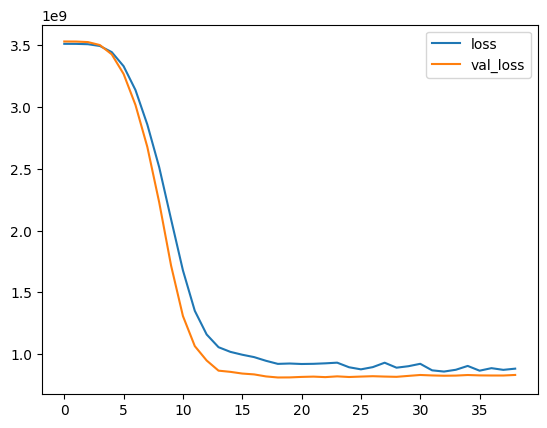

In [55]:

# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [56]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1)
])


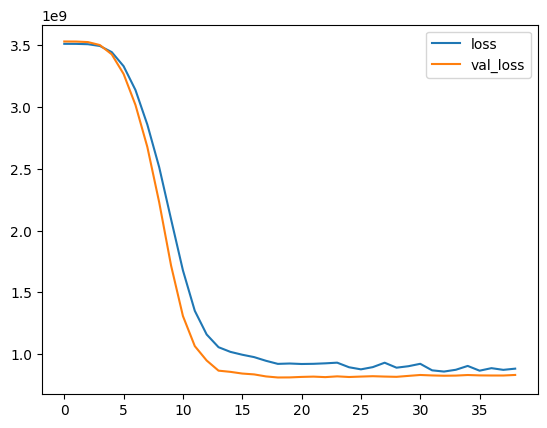

In [57]:

# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [58]:
# %% Predict on test set
Y_pred = model.predict(X_test)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [59]:
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2 = r2_score(Y_test, Y_pred)

print(f"""
Mean Absolute Error: {mae:.2f}
Root Mean Squared Error: {rmse:.2f}
R² Score: {r2:.2f}
""")

mae_test = mean_absolute_error(Y_test, Y_pred)

# Calculate the mean of Y (target variable)
mean_y = Y_test.mean()

# Calculate the percentage of MAE relative to the mean of Y
mae_percentage = (mae_test / mean_y) * 100

print(f"The Mean Absolute Error is {mae_test:.2f}, which is {mae_percentage:.2f}% of the mean of Y.")
print(f"This means if our model makes a prediction it'll be +-{mae_percentage:.2f}% trustworthy")


Mean Absolute Error: 52408.90
Root Mean Squared Error: 59411.30
R² Score: -3.51

The Mean Absolute Error is 52408.90, which is 100.00% of the mean of Y.
This means if our model makes a prediction it'll be +-100.00% trustworthy


In [67]:
from sklearn.model_selection import cross_val_score, KFold
from scikeras.wrappers import KerasRegressor


def build_model():
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

keras_reg = KerasRegressor(build_fn=build_model, epochs=300, batch_size=32, verbose=0)
kfold = KFold(n_splits=5)
results = cross_val_score(keras_reg, X_train, Y_train, cv=kfold)
print(f"Cross-validation MAE: {results.mean()}")

c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which poi

Cross-validation MAE: -0.019979812629606953


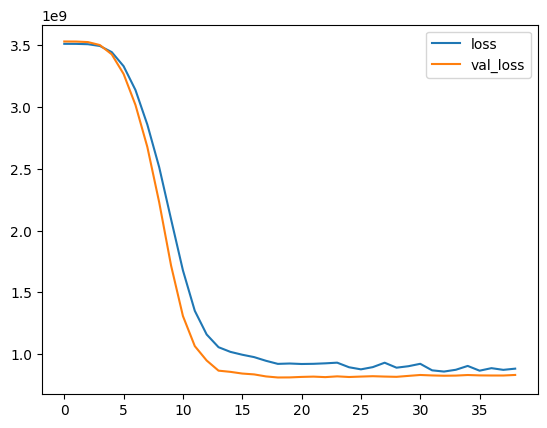

In [68]:

# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [69]:
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2 = r2_score(Y_test, Y_pred)

print(f"""
Mean Absolute Error: {mae:.2f}
Root Mean Squared Error: {rmse:.2f}
R² Score: {r2:.2f}
""")

mae_test = mean_absolute_error(Y_test, Y_pred)

# Calculate the mean of Y (target variable)
mean_y = Y_test.mean()

# Calculate the percentage of MAE relative to the mean of Y
mae_percentage = (mae_test / mean_y) * 100

print(f"The Mean Absolute Error is {mae_test:.2f}, which is {mae_percentage:.2f}% of the mean of Y.")
print(f"This means if our model makes a prediction it'll be +-{mae_percentage:.2f}% trustworthy")


Mean Absolute Error: 52408.90
Root Mean Squared Error: 59411.30
R² Score: -3.51

The Mean Absolute Error is 52408.90, which is 100.00% of the mean of Y.
This means if our model makes a prediction it'll be +-100.00% trustworthy
